In [1]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.collections import PatchCollection
from matplotlib.colors import to_rgba
from matplotlib.patches import Circle
%matplotlib inline

sys.path.append('/mnt/data1/spatial/tissue-alignment/traversal')
from io_utils import read_image, read_spatial_data
from plot import draw_clusters

sys.path.append('/mnt/data1/spatial/belayer/src')
from utils_IO import read_input_10xdirectory, read_boundary_list
from region_cost_fun import fill_geometry
from spatialcoord import spatialcoord
from harmonic import harmonic

In [6]:
def align(dz, section):
    section_path = f'/mnt/data1/spatial/data/colon/{dz}/{section}'
    boundary_file=f'colon-{dz}-{section}-boundaries.npy'
    # boundary_file = f'colon-{dz}-{section}-boundaries-coords.npy'
    fullres = False
    im = read_image(section_path, fullres)
    bound_im_path = f'colon-{dz}-{section}-segmented.png'
    im2 = None
    if os.path.exists(bound_im_path):
        from PIL import Image
        im2 = Image.open(bound_im_path)
    pos_df, spot_radius = read_spatial_data(section_path, fullres)

    count, coords, barcodes, gene_labels = read_input_10xdirectory(section_path)

    G, N=count.shape

    # fill in gaps in 10x hexagonal grid
    fullpoints, in_tissue = fill_geometry(coords, is_hexagon=True)

    # get boundary points
    boundary_list = read_boundary_list(boundary_file, fullpoints)

    spos = spatialcoord(x = fullpoints[:,0], y = fullpoints[:,1])
    har = harmonic(fullpoints, spos.adjacency_mat, np.sqrt(spos.pairwise_squared_dist))

    interpolation = har.interpolation_using_list( boundary_list )
    depth = interpolation[in_tissue]

    pos_df.loc[pos_df['barcode'].argsort(), 'depth'] = depth
    pos_df['depth2'] = pos_df['depth'].round().astype(int)
    pos_df['depth2'] = pos_df['depth2'] - pos_df['depth2'].min() # make min 0

    # bounds = np.load(boundary_idx_file, allow_pickle=True)
    depths = pos_df[['depth', 'depth2']]

    figsize = 8
    fontsize = 15
    nrows = 1
    ncols = 2

    plt.close()
    fig, (axa, axb) = plt.subplots(nrows, ncols, figsize=(figsize*ncols, figsize*nrows))

    axa.imshow(im)
    axb.imshow(np.asarray(im.convert("L")), cmap='gray', vmin=0, vmax=255)
    axa.set_axis_off()
    axb.set_axis_off()

    cm_name = 'gist_rainbow'
    cmap = colormaps[cm_name]
    cmap_interp = np.linspace(0, 1, depths['depth2'].max() + 1)

    temp = np.load(boundary_file, allow_pickle=True)
    bounds = []
    for b in temp:
        mask = [f'{row}-{col}' for row, col in b]
        row_col = pd.DataFrame(
            {'idx': np.arange(len(pos_df))},
            index=pos_df['row'].astype(str) + "-" + pos_df['col'].astype(str)
        )
        bounds.append(row_col.loc[mask, 'idx'].to_numpy())
    for b in bounds:
        bound_coords = pos_df.loc[b, ['x', 'y']].sort_values('y').to_numpy()
        avg_bound_depth = int(round(depths.loc[b, 'depth2'].mean()))
        color = cmap(cmap_interp[avg_bound_depth])
        for x, y in bound_coords:
            circ = Circle((x, y), spot_radius, color=color)
            axa.add_artist(circ)

    circs = PatchCollection(
        [Circle((x, y), spot_radius) for x, y in pos_df[["x", "y"]].to_numpy()],
        picker=True,
    )
    facecolors = np.asarray([list(to_rgba("lightgray"))] * len(pos_df))
    edgecolors = np.asarray([list(to_rgba("darkgray"))] * len(pos_df))
    alphas = np.full(len(pos_df), 1)
    circs.set_facecolor(facecolors)
    circs.set_edgecolor(edgecolors)
    circs.set_alpha(alphas)
    axb.add_collection(circs)

    axa.set_title('Annotated Boundaries', fontsize=fontsize*2)
    axb.set_title('Belayer Alignment', fontsize=fontsize*2)

    fig.tight_layout()
    fig.subplots_adjust(top=0.925, left=0.025)

    dummy_path_idxs = [-1] * (depths['depth2'].max() + 1)
    draw_clusters(
        fig=fig,
        ax=axb,
        path_idxs=dummy_path_idxs,
        clusters=depths['depth2'],
        circs=circs,
        facecolors=facecolors,
        edgecolors=edgecolors,
        cm_name=cm_name,
    )

    axa_bbox = axa.get_position()
    axb_bbox = axb.get_position()

    def _panel_label_coords(bbox, xoffset=0.02, yoffset=0.01):
        x = bbox.xmin - bbox.width * xoffset
        y = bbox.ymax + bbox.height * yoffset
        return x, y

    fig.text(*_panel_label_coords(axa_bbox), 'A', ha='right', va='bottom', fontsize=fontsize*2, weight='bold')
    fig.text(*_panel_label_coords(axb_bbox), 'B', ha='right', va='bottom', fontsize=fontsize*2, weight='bold')

    fig.savefig(f'fig6-{dz}-{section}.png')
    # fig.savefig(f'fig6-{dz}-{section}.pdf')

In [ ]:
for dz in ['CD', 'UC']:
    for seciton in 'ABCD':
        align(dz, seciton)

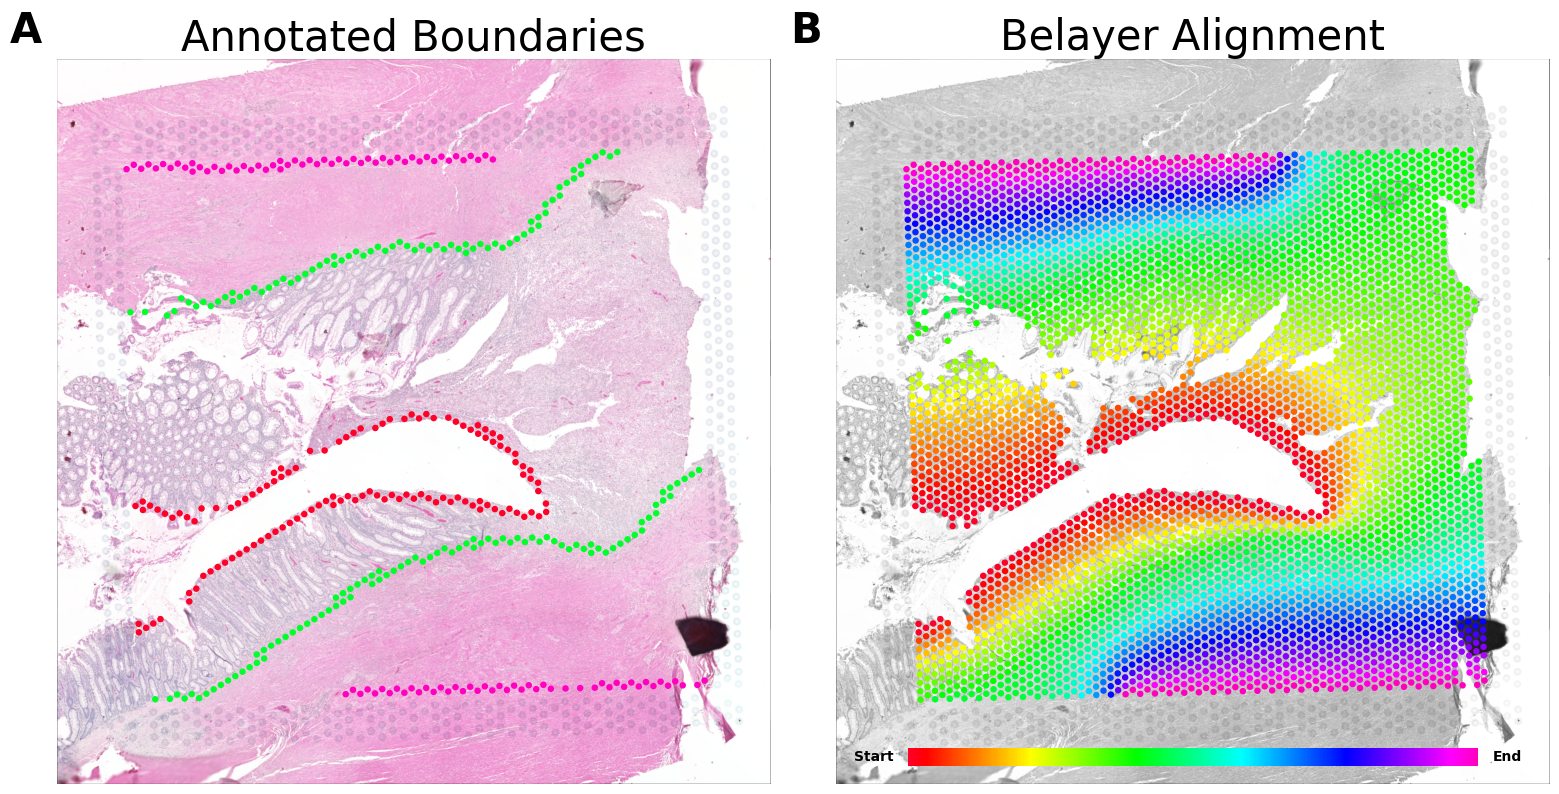

In [8]:
align('CD', 'A')
align('CD', 'B')
align('CD', 'C')

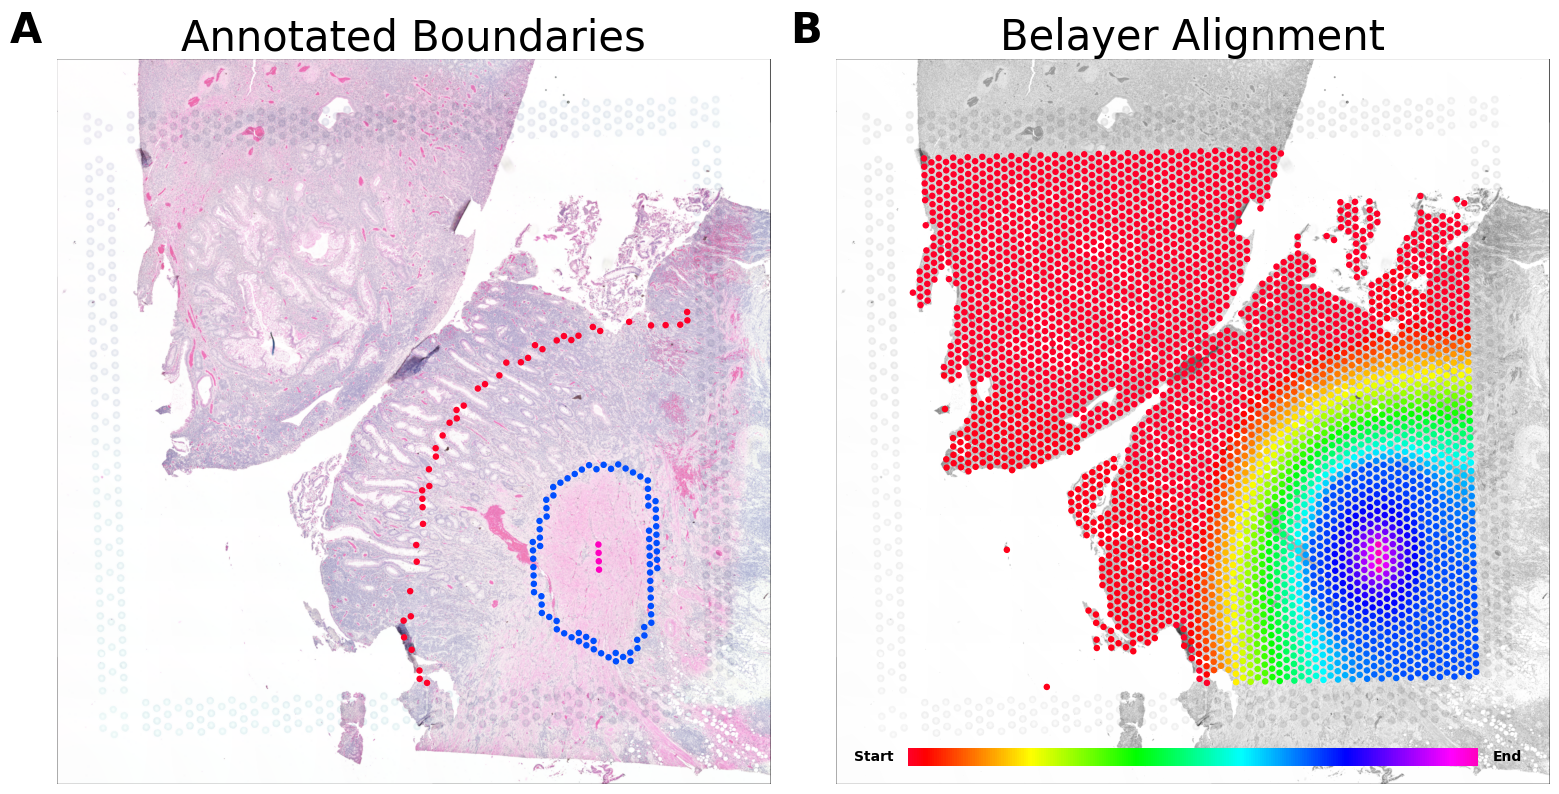

In [10]:
align('CD', 'A')